# Landau-Zener Sweep Simulation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import numpy as np
import time

In [2]:
def hamiltonian(args):
    """ evaluate the hamiltonian,
        args: [Delta, Omega]"""
    H0 = np.array([[-0.5*args[0], -1j*args[1]],
                         [1j*args[1], 0.5*args[0]]])
    return H0

def HS1(t, args):
    """ evaluate the HS1-pulse,
        args: [Period, Omega0, Delta0, Deltac, hspar]"""
    Omega = 1.0 * args[1] / np.cosh(args[4] * 2 * np.pi * (t/args[0]-0.5))
    Delta = 1.0 * args[2] * np.tanh(args[4] * 2 * np.pi * (t/args[0]-0.5)) + args[3]
    
    return Omega, Delta

def evo(args):
    """ evaluate step evolution of two-level system,
        args: [psi0, tlist, Delta, Omega]"""
    psi0 = args[0]
    tlist = args[1]
    Delta = args[2]
    Omega = args[3]
    
    dt = tlist[1] - tlist[0]
    psi = [psi0]
    occ = [np.multiply(psi0,psi0.conj())]
    for ci,ti in enumerate(tlist):
        H0 = hamiltonian([Delta[ci], Omega[ci]])
        psii = np.dot(linalg.expm(-1j * dt * H0), psi[ci])
        occi = np.real(np.multiply(psii,psii.conj()))
        psi.append(psii)
        occ.append(occi)

    psi = np.array(psi[:-1])
    occ = np.array(occ[:-1])
    
    return psi, occ

## 1. Landau-Zener pulse

In [3]:
def getsweep(args, tsteps = 500, isshow = True):
    Period = args[0]
    Omega0 = args[1]
    Delta0 = args[2]
    Deltac = args[3]
    noise0 = args[4]/3
    noise1 = args[5]
    freq1  = args[6]
    sweeps = int(args[7])
    
    tlist = np.linspace(0, 1.0, tsteps) * Period
    
    Omega, Delta = HS1(tlist, [Period, Omega0, Delta0, Deltac, 1.6])
    psi0 = np.array([1,0])
    psi1 = np.array([0,1])
    # calculate the evolution
    start_time = time.time()
    
    if sweeps > 1:
        sweeptlist = np.array([])
        sweepDelta = np.array([])
        sweepOmega = np.array([])
        sweepnoise = np.array([])
        for cs in range(sweeps):
            sweeptlist = np.append(sweeptlist, tlist + cs * Period)
            sweepDelta = np.append(sweepDelta, Delta[::((-1)**cs)])
            sweepOmega = np.append(sweepOmega, Omega[::((-1)**cs)])
            sweepnoise = np.append(sweepnoise, noise0 * np.random.randn(len(tlist)) +
                                   noise1 * np.sin(2 * np.pi * freq1 * tlist 
                                                   + np.pi * np.random.randn()))
            
        tlist = sweeptlist
        Delta = sweepDelta
        Omega = sweepOmega
        noisec = sweepnoise
        
    else:
        noisec = noise0 * np.random.randn(len(tlist)) + noise1 * np.sin(2 * np.pi * freq1 * tlist + np.pi * np.random.randn())
     
    Delta = Delta + noisec
        
    if sweeps > 1:
        for cs in range(sweeps):
            _, occ0 = evo([psi0, tlist[(cs * tsteps) : (cs * tsteps + tsteps)], 
                           Delta[(cs * tsteps) : (cs * tsteps + tsteps)], 
                           Omega[(cs * tsteps) : (cs * tsteps + tsteps)]])
            
            if cs == 0:
                occ = occ0
            else:
                _, occ1 = evo([psi1, tlist[(cs * tsteps) : (cs * tsteps + tsteps)],
                               Delta[(cs * tsteps) : (cs * tsteps + tsteps)],
                               Omega[(cs * tsteps) : (cs * tsteps + tsteps)]])
                occ = np.append(occ, occ[-1, 0] * occ0 + occ[-1, 1] * occ1, axis = 0)
            
    else:
        _, occ = evo([psi0, tlist, Delta, Omega])
    
    if isshow:
        print('time elapsed %.2f s'%(time.time() - start_time))
        print('efficiency: %.4f'%(occ[-1, 1]))

        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True, figsize=(6,5))
        ax[0].plot(tlist * 1000, occ)
        ax[0].set_ylabel('Occupation', fontsize = 14)
        ax[1].plot(tlist * 1000, Delta / (1000.0 * 2 * np.pi), tlist * 1000, Omega / (1000.0 * 2 * np.pi))
        ax[1].set_ylabel('$\Delta$, $\Omega$ (kHz)', fontsize = 14)
        ax[1].set_xlabel('Time (ms)', fontsize = 14)
        plt.suptitle('L-Z Pulse %.2g sweeps\n @ T=%.2g ms, $\Omega$=%.2g kHz, $\Delta_R$=%.2g kHz'
                     %(sweeps, Period*1000.0, Omega0/(1000.0 * 2 * np.pi), Delta0/(1000.0 * 2 * np.pi)), fontsize = 16)
        plt.subplots_adjust(hspace=0.025)
        plt.show()
    else:        
        return occ

time elapsed 0.17 s
efficiency: 0.9998


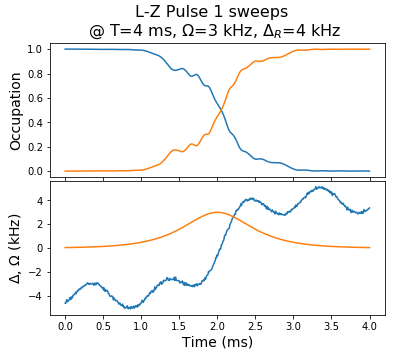

time elapsed 6.00 s
efficiency: 0.0275


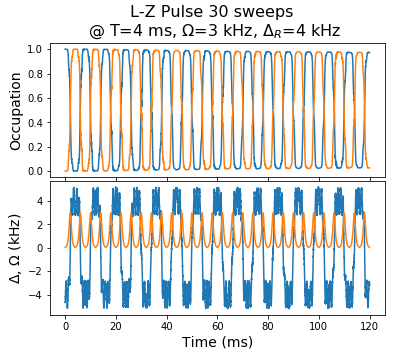

In [4]:
# set up the calculation
Period = 4.0 * 0.001 # Sweep time
Omega0 = 3.0 * 1000.0 * 2 * np.pi # Rabi strength
Delta0 = 4.0 * 1000.0 * 2 * np.pi # Half of sweeping frequency range
Deltac = 0.0 * 1000.0 * 2 * np.pi # Sweeping frequency center
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise, peak-peak * 0.5
noise1 = 0.5 * 2100.0 * 2 * np.pi # spec noise, peak-peak * 0.5
freq1 = 1.0 * 1000.0

getsweep([Period, Omega0, Delta0, Deltac, noise0, noise1, freq1, 1])
getsweep([Period, Omega0, Delta0, Deltac, noise0, noise1, freq1, 30])

time elapsed 0.11 s
efficiency: 0.9989


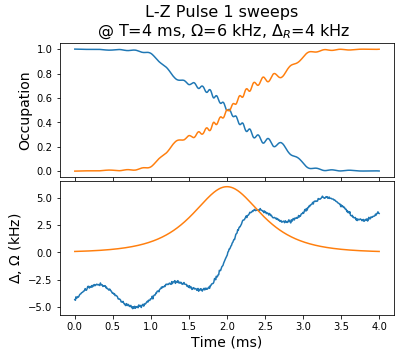

time elapsed 5.94 s
efficiency: 0.0544


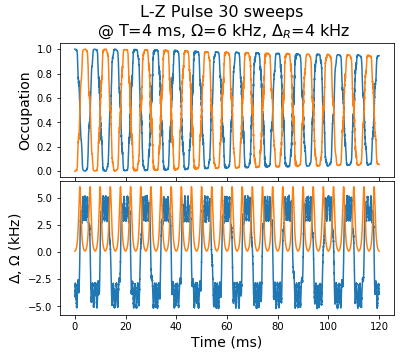

In [5]:
# set up the calculation
Period = 4.0 * 0.001 # Sweep time
Omega0 = 6.0 * 1000.0 * 2 * np.pi # Rabi strength
Delta0 = 4.0 * 1000.0 * 2 * np.pi # Half of sweeping frequency range
Deltac = 0.0 * 1000.0 * 2 * np.pi # Sweeping frequency center
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise
noise1 = 0.5 * 2100.0 * 2 * np.pi # spec noise
freq1 = 1.0 * 1000.0

getsweep([Period, Omega0, Delta0, Deltac, noise0, noise1, freq1, 1])
getsweep([Period, Omega0, Delta0, Deltac, noise0, noise1, freq1, 30])

## 2. Landau-Zenner Spectrum

In [ ]:
def getspec(args, isnoise = False, tsteps = 500):
    Period = args[0]
    Omega0 = args[1]
    Delta0 = args[2]
    Deltac = np.linspace(-abs(args[3]), abs(args[3]), 100)
    noise0 = args[4]
    noise1 = args[5]
    freq1 = args[6]
    sweeps = args[7]
    
    start_time = time.time()
    eta0 = np.zeros(len(Deltac))
    for ci, cdc in enumerate(Deltac):
        occ = getsweep([Period, Omega0, Delta0, cdc, 0.0 * noise0, 0.0 * noise1, freq1, sweeps], tsteps, False)
        eta0[ci] = occ[-1,1]
    
    if isnoise:
        eta1 = np.zeros(len(Deltac))
        std1 = np.zeros(len(Deltac))
        samplesize = 20
        for ci, cdc in enumerate(Deltac):
            etac = np.zeros(samplesize)
            for cc in range(samplesize):
                occ = getsweep([Period, Omega0, Delta0, cdc, 1.0 * noise0, 1.0 * noise1, freq1, sweeps], tsteps, False)
                etac[cc] = occ[-1,1]
            eta1[ci] = np.mean(etac)
            std1[ci] = np.std(etac)

    print('time elapsed = %.2f s'%(time.time() - start_time))

    fig = plt.figure(figsize=[6,4])
    ax = fig.add_axes([0.15,0.15,0.8,0.75])
    if isnoise:
        ax.errorbar(Deltac / (1000.0 * 2 * np.pi), eta1[:], yerr=std1[:], fmt='o')
    ax.plot(Deltac / (1000.0 * 2 * np.pi), eta0[:], '-')
    ax.set_ylim([-0.05, 1.05])
    ax.grid(color='gray', linestyle='--')
    ax.set_xlabel('$\Delta$ (kHz)', fontsize = 14)
    ax.set_ylabel('Efficiency', fontsize = 14)
    ax.set_title('L-Z Spectrum\n @ T=%.2g ms, $\Omega$=%.2g kHz, $\Delta_R$=%.2g kHz'
                 %(Period*1000.0, Omega0/(1000.0 * 2 * np.pi), Delta0/(1000.0 * 2 * np.pi)), fontsize = 16)
    plt.show()

## (1a): $\Omega=3$ kHz, $T=10$ ms, $\delta_0 = 0.1$ mG, $\delta_1 = 0$ mG @ 1 kHz

time elapsed = 227.76 s


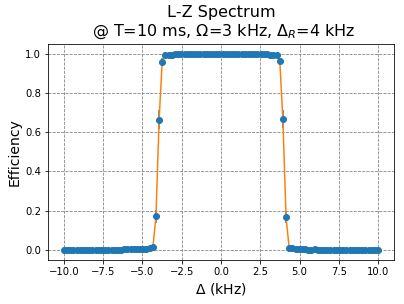

In [ ]:
Period = 10.0 * 0.001
Omega0 = 3.0 * 1000.0 * 2 * np.pi
Delta0 = 4.0 * 1000.0 * 2 * np.pi
FreqSc = 10.0 * 1000.0 * 2 * np.pi
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise
noise1 = 0.0 * 2100.0 * 2 * np.pi # spec noise
freq1 = 1.0 * 1000.0

getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 1], isnoise= True, tsteps = 500)
getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 2], isnoise= True, tsteps = 500)

## (1b): $\Omega=3$ kHz, $T=10$ ms, $\delta_0 = 0.1$ mG, $\delta_1 = 0.5$ mG @ 1 kHz

In [ ]:
Period = 10.0 * 0.001
Omega0 = 3.0 * 1000.0 * 2 * np.pi
Delta0 = 4.0 * 1000.0 * 2 * np.pi
FreqSc = 10.0 * 1000.0 * 2 * np.pi
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise
noise1 = 0.5 * 2100.0 * 2 * np.pi # spec noise
freq1 = 1.0 * 1000.0

getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 1], isnoise= True, tsteps = 500)
getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 2], isnoise= True, tsteps = 500)

## (1c): $\Omega=3$ kHz, $T=4$ ms, $\delta_0 = 0.1$ mG, $\delta_1 = 0$ mG @ 1 kHz

In [ ]:
Period = 4.0 * 0.001
Omega0 = 3.0 * 1000.0 * 2 * np.pi
Delta0 = 4.0 * 1000.0 * 2 * np.pi
FreqSc = 10.0 * 1000.0 * 2 * np.pi
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise
noise1 = 0.0 * 2100.0 * 2 * np.pi # spec noise
freq1 = 1.0 * 1000.0

getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 1], isnoise= True, tsteps = 200)
getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 2], isnoise= True, tsteps = 200)

## (1d): $\Omega=3$ kHz, $T=4$ ms, $\delta_0 = 0.2$ mG, $\delta_1 = 0.5$ mG @ 1 kHz

In [ ]:
Period = 4.0 * 0.001
Omega0 = 3.0 * 1000.0 * 2 * np.pi
Delta0 = 4.0 * 1000.0 * 2 * np.pi
FreqSc = 10.0 * 1000.0 * 2 * np.pi
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise
noise1 = 0.5 * 2100.0 * 2 * np.pi # spec noise
freq1 = 1.0 * 1000.0

getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 1], isnoise= True, tsteps = 200)
getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 2], isnoise= True, tsteps = 200)

# (2a): $\Omega=6$ kHz, $T=10$ ms, $\delta_0 = 0.1$ mG, $\delta_1 = 0$ mG @ 1 kHz

In [ ]:
Period = 10.0 * 0.001
Omega0 = 6.0 * 1000.0 * 2 * np.pi
Delta0 = 4.0 * 1000.0 * 2 * np.pi
FreqSc = 10.0 * 1000.0 * 2 * np.pi
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise
noise1 = 0.0 * 2100.0 * 2 * np.pi # spec noise
freq1 = 1.0 * 1000.0

getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 1], isnoise= True, tsteps = 500)
getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 2], isnoise= True, tsteps = 500)

# (2b): $\Omega=6$ kHz, $T=10$ ms, $\delta_0 = 0.1$ mG, $\delta_1 = 0.5$ mG @ 1 kHz

In [ ]:
Period = 10.0 * 0.001
Omega0 = 6.0 * 1000.0 * 2 * np.pi
Delta0 = 4.0 * 1000.0 * 2 * np.pi
FreqSc = 10.0 * 1000.0 * 2 * np.pi
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise
noise1 = 0.5 * 2100.0 * 2 * np.pi # spec noise
freq1 = 1.0 * 1000.0

getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 1], isnoise= True, tsteps = 500)
getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 2], isnoise= True, tsteps = 500)

# (2c): $\Omega=6$ kHz, $T=4$ ms, $\delta_0 = 0.1$ mG, $\delta_1 = 0$ mG @ 1 kHz

In [ ]:
Period = 4.0 * 0.001
Omega0 = 6.0 * 1000.0 * 2 * np.pi
Delta0 = 4.0 * 1000.0 * 2 * np.pi
FreqSc = 10.0 * 1000.0 * 2 * np.pi
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise
noise1 = 0.0 * 2100.0 * 2 * np.pi # spec noise
freq1 = 1.0 * 1000.0

getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 1], isnoise= True, tsteps = 200)
getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 2], isnoise= True, tsteps = 200)

## (2d): $\Omega=6$ kHz, $T=4$ ms, $\delta_0 = 0.1$ mG, $\delta_1 = 0.5$ mG @ 1 kHz

In [ ]:
Period = 4.0 * 0.001
Omega0 = 6.0 * 1000.0 * 2 * np.pi
Delta0 = 4.0 * 1000.0 * 2 * np.pi
FreqSc = 10.0 * 1000.0 * 2 * np.pi
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise
noise1 = 0.5 * 2100.0 * 2 * np.pi # spec noise
freq1 = 1.0 * 1000.0

getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 1], isnoise= True, tsteps = 200)
getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 2], isnoise= True, tsteps = 200)

## (2e): $\Omega=6$ kHz, $T=2$ ms, $\delta_0 = 0.1$ mG, $\delta_1 = 0$ mG @ 1 kHz

In [ ]:
Period = 2.0 * 0.001
Omega0 = 6.0 * 1000.0 * 2 * np.pi
Delta0 = 4.0 * 1000.0 * 2 * np.pi
FreqSc = 10.0 * 1000.0 * 2 * np.pi
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise
noise1 = 0.0 * 2100.0 * 2 * np.pi # spec noise
freq1 = 1.0 * 1000.0

getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 1], isnoise= True, tsteps = 200)
getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 2], isnoise= True, tsteps = 200)

## (2f): $\Omega=6$ kHz, $T=2$ ms, $\delta_0 = 0.1$ mG, $\delta_1 = 0.5$ mG @ 1 kHz

In [ ]:
Period = 2.0 * 0.001
Omega0 = 6.0 * 1000.0 * 2 * np.pi
Delta0 = 4.0 * 1000.0 * 2 * np.pi
FreqSc = 10.0 * 1000.0 * 2 * np.pi
noise0 = 0.1 * 2100.0 * 2 * np.pi # white noise
noise1 = 0.5 * 2100.0 * 2 * np.pi # spec noise
freq1 = 1.0 * 1000.0

getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 1], isnoise= True, tsteps = 200)
getspec([Period, Omega0, Delta0, FreqSc, noise0, noise1, freq1, 2], isnoise= True, tsteps = 200)